<a href="https://colab.research.google.com/github/aguscura/UBA-data-science/blob/main/spark_S32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**S32:** Yelp tiene la teoría de que quienes hacen las reviews más útiles en la plataforma son aquellos usuarios con más antigüedad. Para probar está hipótesis para cada review consiga la suma total de sus votos (funny + cool + useful) y correlacionela con la antigüedad del usuario al momento de hacer la review. (3 PUNTOS).


In [1]:
# !pip install pyspark
# !pip install -U -q PyDrive
# !apt update
# !apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 33 kB/s 
     |████████████████████████████████| 199 kB 52.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=4dda6c456517e3991d8cc8b005c559b059b2da7d0042d723b30fe27314f06139
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
from tqdm import tqdm
from datetime import date
from datetime import datetime, timedelta

In [5]:
#Creamos el Spark Context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

#**Reviews más utiles**

In [3]:
!gdown "1okxCrPipVJmexBSVZ34kJlttw02-7kTX"

Downloading...
From: https://drive.google.com/uc?id=1okxCrPipVJmexBSVZ34kJlttw02-7kTX
To: /content/review.csv
100% 2.43G/2.43G [01:08<00:00, 35.3MB/s]


**Para el review.csv, no hago el pasaje a parquet porque no me da el RAM**

In [ ]:
# df = pd.read_csv("/content/review.csv")
# df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [ ]:
# df = pd.read_csv("/content/review.csv", usecols=["user_id","text", "date"])
# df.to_parquet("/content/review.parquet")

In [ ]:
#Leemos archivo parquet
# sqlContext = SQLContext(sc)
# rdd_2 = sqlContext.read.parquet('/content/review.parquet').rdd.repartition(2)

In [6]:
sqlContext = SQLContext(sc)
df = sqlContext.read.csv('/content/review.csv', header=True, inferSchema=True)
rdd_2 = df.rdd

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [21]:
rdd_2.take(2)

[Row(review_id='KU_O5udG6zpxOg-VcAEodg', user_id='mh_-eMZ6K5RLWhZyISBhwA', business_id='XQfwVwDr-v0ZS3_CbbE5Xw', stars='3.0', useful='0.0', funny='0.0', cool='0.0', text="If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. ", date=None),
 Row(review_id='The food is good', user_id=' but it takes a very long time to come out. The waitstaff is very young', business_id=' but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends', stars=' in order to be done quicker."', useful='2018-07-07 22:09:11', funny=None, cool=None, text=None, date=None)]

**'useful' con cualquier cosa**

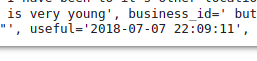

Voy a buscar **para cada review** la suma total de sus votos (funny + cool + useful). Tengo que mantener el user_id como key para despues traerme la antiguedad.

Los None los filtro. Podría reemplazarlos por cero, pero creo es más representativo filtrarlos (tal vez es una review muy buena pero que simplemente nadie le cargó puntaje)

**Obtengo**

('user_id' , (votos, fecha de la review) )

In [64]:
rdd_3 = rdd_2.filter(lambda x:  (x.funny != None)   and   (x.cool != None)  and   (x.useful != None) and (x.date != None) ) #Filtro None
rdd_4 = rdd_3.filter(lambda x: len(x.funny)== 3 and len(x.cool) == 3  and len(x.useful) ==3 ) #Como hay otras cosas en los puntajes, filtro por len de string = 3 (Ej. 0.0)
rdd_5 = rdd_4.filter(lambda x:  (len(x.date) == 19)  and   (":" in x.date) and  ("-" in x.date) and ("/" not in x.date) ) #Filtro solo fechas con formato ok
rdd_5.filter(lambda x: "." in (x.funny and x.cool and x.useful) ).map(lambda x: (x.user_id, (float(x.funny) + float(x.cool) + float(x.useful), datetime.strptime(x.date, '%Y-%m-%d %H:%M:%S') ) )).take(10) #Me sigue trayendo strings de len 3 con cualquier cosa, filtro por "."


[('bcjbaE6dDog4jkNY91ncLQ', (2.0, datetime.datetime(2017, 1, 14, 20, 54, 15))),
 ('Jha0USGDMefGFRLik_xFQg', (0.0, datetime.datetime(2017, 2, 19, 13, 32, 5))),
 ('QzCEzH3R7Z6erOGLr3t55Q', (2.0, datetime.datetime(2017, 5, 26, 13, 10, 24))),
 ('yFuE8SPF-d1GXJUWYgKtzg', (0.0, datetime.datetime(2017, 5, 13, 14, 15, 29))),
 ('qEEk0PuoH1dVa619t8fgpw', (0.0, datetime.datetime(2017, 9, 20, 16, 16, 47))),
 ('aFa96pz67TwOFu4Weq5Agg', (0.0, datetime.datetime(2018, 8, 23, 21, 39, 38))),
 ('iYY5Ii1LGpZCpXFkHlMefw', (0.0, datetime.datetime(2018, 4, 27, 23, 3, 21))),
 ('S7bjj-L07JuRr-tpX1UZLw', (0.0, datetime.datetime(2018, 7, 7, 20, 50, 12))),
 ('bHSoye7R5cL-LVWLxtaxMg', (2.0, datetime.datetime(2017, 9, 8, 23, 20, 19))),
 ('IMd3NQbclta91pFKk3AJZg', (0.0, datetime.datetime(2017, 4, 8, 0, 33, 11)))]

In [65]:
rdd_6 = rdd_5.filter(lambda x: "." in (x.funny and x.cool and x.useful) ).map(lambda x: (x.user_id, (float(x.funny) + float(x.cool) + float(x.useful), datetime.strptime(x.date, '%Y-%m-%d %H:%M:%S') ) ))

# Busco antiguedad del usuario **al momento de hacer la review**

In [28]:
!gdown "1owjSBHKLx0pJMdQYtKUIfiXqBV3lfCdS"

Downloading...
From: https://drive.google.com/uc?id=1owjSBHKLx0pJMdQYtKUIfiXqBV3lfCdS
To: /content/user.csv
100% 2.71G/2.71G [00:17<00:00, 156MB/s]


In [29]:
#Chequeo columnas del df
df = pd.read_csv("/content/user.csv")
df.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

Paso el csv a parquet. Por un tema de RAM solo me traigo algunas columnas

In [30]:
#Paso a parquet. Acá solo tomo algunas columnas por el RAM
df = pd.read_csv("/content/user.csv", usecols=["user_id", "yelping_since"])
df.to_parquet("/content/user.parquet")

In [69]:
#Leemos archivo parquet
sqlContext = SQLContext(sc)
rdd = sqlContext.read.parquet('/content/user.parquet').rdd.repartition(2)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [70]:
rdd.take(5)

[Row(user_id='qVc8ODYU5SZjKXVBgXdI7w', yelping_since='2007-01-25 16:47:26'),
 Row(user_id='j14WgRoU_-2ZE1aw1dXrJg', yelping_since='2009-01-25 04:35:42'),
 Row(user_id='2WnXYQFK0hXEoTxPtV2zvg', yelping_since='2008-07-25 10:41:00'),
 Row(user_id='SZDeASXq7o05mMNLshsdIA', yelping_since='2005-11-29 04:38:33'),
 Row(user_id='hA5lMy-EnncsH4JoR-hFGQ', yelping_since='2007-01-05 19:40:59')]

In [71]:
rdd.filter(lambda x:  (len(x.yelping_since) == 19)  and   (":" in x.yelping_since) and  ("-" in x.yelping_since) ).map(lambda x: (x.user_id, datetime.strptime(x.yelping_since, '%Y-%m-%d %H:%M:%S'))).take(5)

[('qVc8ODYU5SZjKXVBgXdI7w', datetime.datetime(2007, 1, 25, 16, 47, 26)),
 ('j14WgRoU_-2ZE1aw1dXrJg', datetime.datetime(2009, 1, 25, 4, 35, 42)),
 ('2WnXYQFK0hXEoTxPtV2zvg', datetime.datetime(2008, 7, 25, 10, 41)),
 ('SZDeASXq7o05mMNLshsdIA', datetime.datetime(2005, 11, 29, 4, 38, 33)),
 ('hA5lMy-EnncsH4JoR-hFGQ', datetime.datetime(2007, 1, 5, 19, 40, 59))]

In [72]:
rdd = rdd.filter(lambda x:  (len(x.yelping_since) == 19)  and   (":" in x.yelping_since) and  ("-" in x.yelping_since) ).map(lambda x: (x.user_id, datetime.strptime(x.yelping_since, '%Y-%m-%d %H:%M:%S')))

**rdd_final**

( user_id , ( fecha de creación de cuenta ,   (puntos totales review,   fecha review )                                 )

Hago el Join. Todavia no hay reduce. O sea que puede haber varias líneas con el mismo user. Para cada review, habra una línea con el user, la fecha de creación de ese user y la fecha de la review.

In [74]:
rdd_final = rdd.join(rdd_6)
rdd_final.take(5)

[('MPQ5-SkAcPW5_uLn-7_jCw',
  (datetime.datetime(2009, 3, 16, 18, 16, 41),
   (3.0, datetime.datetime(2018, 10, 2, 23, 41, 10)))),
 ('JVHAFY5ijpGyyCtJb6NPcg',
  (datetime.datetime(2010, 8, 13, 18, 59, 54),
   (0.0, datetime.datetime(2018, 6, 12, 3, 42, 6)))),
 ('JVHAFY5ijpGyyCtJb6NPcg',
  (datetime.datetime(2010, 8, 13, 18, 59, 54),
   (0.0, datetime.datetime(2018, 6, 12, 3, 51, 14)))),
 ('JVHAFY5ijpGyyCtJb6NPcg',
  (datetime.datetime(2010, 8, 13, 18, 59, 54),
   (1.0, datetime.datetime(2018, 7, 20, 18, 12, 26)))),
 ('JVHAFY5ijpGyyCtJb6NPcg',
  (datetime.datetime(2010, 8, 13, 18, 59, 54),
   (0.0, datetime.datetime(2021, 5, 23, 18, 10, 16))))]

In [87]:
#Puntos
rdd_final.map(lambda x:  x[1][1][0]).take(5)

[3.0, 0.0, 0.0, 1.0, 0.0]

In [90]:
#Días de antiguedad de la cuenta
rdd_final.map(lambda x: (x[1][1][1] - x[1][0]).days).take(5)

[3487, 2859, 2859, 2897, 3935]

In [89]:
points = rdd_final.map(lambda x:  x[1][1][0])
days = rdd_final.map(lambda x: (x[1][1][1] - x[1][0]).days)

In [86]:
from pyspark.mllib.stat import Statistics

print("Correlation is: " + str(Statistics.corr(points, days, method="pearson")))


Correlation is: 0.1064650490647836


Demasiado baja... raro. Calculo de otra forma

In [92]:
rdd_corr = rdd_final.map(lambda x: [ x[1][1][0] ,  (x[1][1][1] - x[1][0]).days] )
rdd_corr.take(15)

[[3.0, 3487],
 [0.0, 2859],
 [0.0, 2859],
 [1.0, 2897],
 [0.0, 3935],
 [0.0, 2897],
 [1.0, 2859],
 [0.0, 3600],
 [3.0, 2541],
 [4.0, 3250],
 [1.0, 3571],
 [2.0, 5056],
 [7.0, 4399],
 [3.0, 2887],
 [8.0, 3926]]

In [93]:
print(Statistics.corr(rdd_corr, method="pearson"))

[[1.         0.10646505]
 [0.10646505 1.        ]]


**Practicamente no hay relación (~0) entre la positividad de las reviews y la antiguedad del usuario al momento de hacer la review.**